# Exploring Individual Factors Affecting PR Acceptability

## Load (Local) Dataset & Imports

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

data_dir = "./data"
sub_dir = os.path.join(data_dir, "filtered")

pr_df = pd.read_csv(os.path.join(sub_dir, "pull_request.csv"))

pr_df.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,...,accepted,rejected,related_issue,turnaround_time,num_files_changed,touches_test_file,lines_added,lines_deleted,net_churn,total_churn
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,...,False,True,False,273739.0,3.0,True,394.0,2.0,392.0,396.0
1,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,...,True,False,False,363.0,5.0,False,298.0,109.0,189.0,407.0
2,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,...,True,False,False,2288.0,15.0,False,288.0,12.0,276.0,300.0
3,3214555104,16658,Add function signature breaking change detector,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Claude_Code,17039389,harupy,closed,2025-07-09T05:35:26Z,2025-07-11T05:13:35Z,...,True,False,False,171489.0,3.0,True,620.0,0.0,620.0,620.0
4,3214724259,5489,feat: add comprehensive test coverage for form...,## Summary\n\nThis PR enhances the forms plugi...,Claude_Code,82053242,wtfsayo,closed,2025-07-09T06:43:46Z,2025-07-09T06:44:02Z,...,True,False,False,16.0,6.0,True,1013.0,340.0,673.0,1353.0


In [2]:
print("Number of PRs:", pr_df.shape[0])
print("Columns in PR DataFrame:", pr_df.columns.tolist())

Number of PRs: 11962
Columns in PR DataFrame: ['id', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url', 'accepted', 'rejected', 'related_issue', 'turnaround_time', 'num_files_changed', 'touches_test_file', 'lines_added', 'lines_deleted', 'net_churn', 'total_churn']


In [3]:
accepted_prs = pr_df[pr_df['accepted'] == True]
print("Number of accepted PRs:", accepted_prs.shape[0])

rejected_prs = pr_df[pr_df['rejected'] == True]
print("Number of rejected PRs:", rejected_prs.shape[0])

Number of accepted PRs: 8141
Number of rejected PRs: 3821


## Related Issue

In [4]:
def analyze_boolean_factor(df, column_name, label_false='False', label_true='True', title_suffix=''):
    """
    Analyze acceptance rate based on a boolean column and perform chi-square test.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing PR data
    column_name : str
        Name of the boolean column to analyze
    label_false : str
        Label for False values in visualizations
    label_true : str
        Label for True values in visualizations
    title_suffix : str
        Additional text to add to plot titles
    
    Returns:
    --------
    dict : Contains chi2 statistic, p-value, and contingency data
    """
    from scipy.stats import chi2_contingency
    
    # Create contingency table
    contingency_data = df.groupby(column_name).agg({
        'accepted': ['sum', 'count']
    }).reset_index()
    
    contingency_data.columns = [column_name, 'accepted_count', 'total_count']
    contingency_data['rejected_count'] = contingency_data['total_count'] - contingency_data['accepted_count']
    contingency_data['acceptance_rate'] = (contingency_data['accepted_count'] / contingency_data['total_count']) * 100
    
    print(f"Acceptance Rates by {column_name}:")
    print(contingency_data)
    print()
    
    # Perform Chi-square test
    contingency_table = pd.crosstab(df[column_name], df['accepted'])
    print("Contingency Table:")
    print(contingency_table)
    print()
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.20f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Statistical significance: {'Yes (p < 0.005)' if p_value < 0.005 else 'No (p >= 0.005)'}")
    print()
    
    # Visualize the comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart of acceptance rates
    axes[0].bar([label_false, label_true], 
                contingency_data['acceptance_rate'],
                color=['#FF6B6B', '#4ECDC4'],
                edgecolor='black')
    axes[0].set_ylabel('Acceptance Rate (%)')
    axes[0].set_title(f'PR Acceptance Rate: {title_suffix or column_name}')
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add n and percentage labels on bars
    for idx, row in contingency_data.iterrows():
        label = label_false if row[column_name] == False else label_true
        axes[0].text(idx, row['acceptance_rate'] + 2, 
                     f"{row['acceptance_rate']:.1f}%\n(n={int(row['total_count'])})",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Stacked bar chart showing counts
    axes[1].bar([label_false, label_true],
                contingency_data['accepted_count'],
                label='Accepted',
                color='#4ECDC4',
                edgecolor='black')
    axes[1].bar([label_false, label_true],
                contingency_data['rejected_count'],
                bottom=contingency_data['accepted_count'],
                label='Rejected',
                color='#FF6B6B',
                edgecolor='black')
    axes[1].set_ylabel('Number of PRs')
    axes[1].set_title(f'PR Outcomes: {title_suffix or column_name}')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof,
        'contingency_data': contingency_data
    }

Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False            6067         8754            2687        69.305460
1           True            2074         3208            1134        64.650873

Contingency Table:
accepted       False  True 
related_issue              
False           2687   6067
True            1134   2074

Chi-square statistic: 23.1830
P-value: 0.00000147296924850910
Degrees of freedom: 1
Statistical significance: Yes (p < 0.005)



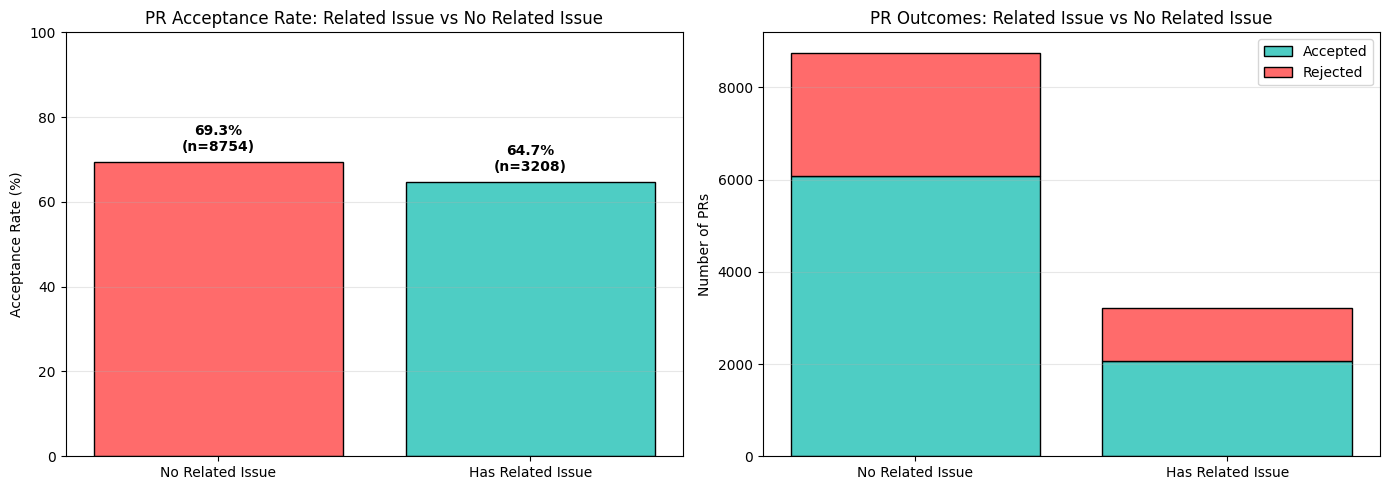

In [5]:
pr_df.columns

pr_df['related_issue'].value_counts()

analyze_boolean_factor(pr_df, 'related_issue', 
                      label_false='No Related Issue', 
                      label_true='Has Related Issue',
                      title_suffix='Related Issue vs No Related Issue')
None

## Number of Files Touched

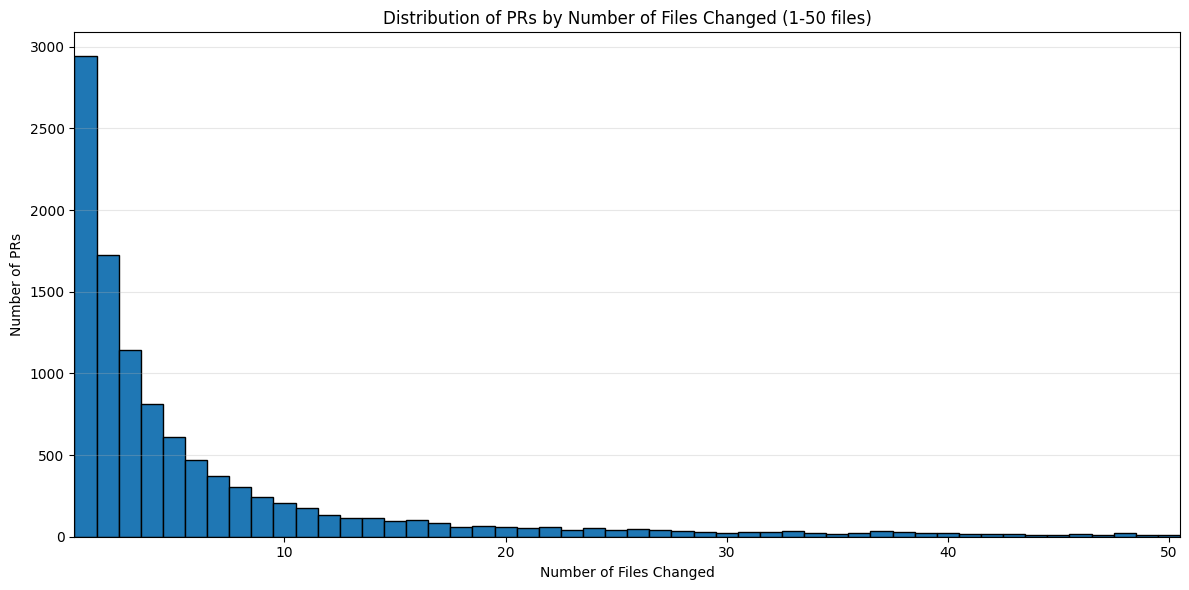

In [6]:
pr_df['num_files_changed'].max()

pr_df[pr_df['num_files_changed'] == pr_df['num_files_changed'].max()]

# Create histogram of number of PRs by files changed (1-50 files)
file_counts = pr_df['num_files_changed'].dropna()
file_counts = file_counts[file_counts <= 50]

plt.figure(figsize=(12, 6))
plt.hist(file_counts, bins=range(1, 52), edgecolor='black', align='left')
plt.xlabel('Number of Files Changed')
plt.ylabel('Number of PRs')
plt.title('Distribution of PRs by Number of Files Changed (1-50 files)')
plt.xlim(0.5, 50.5)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

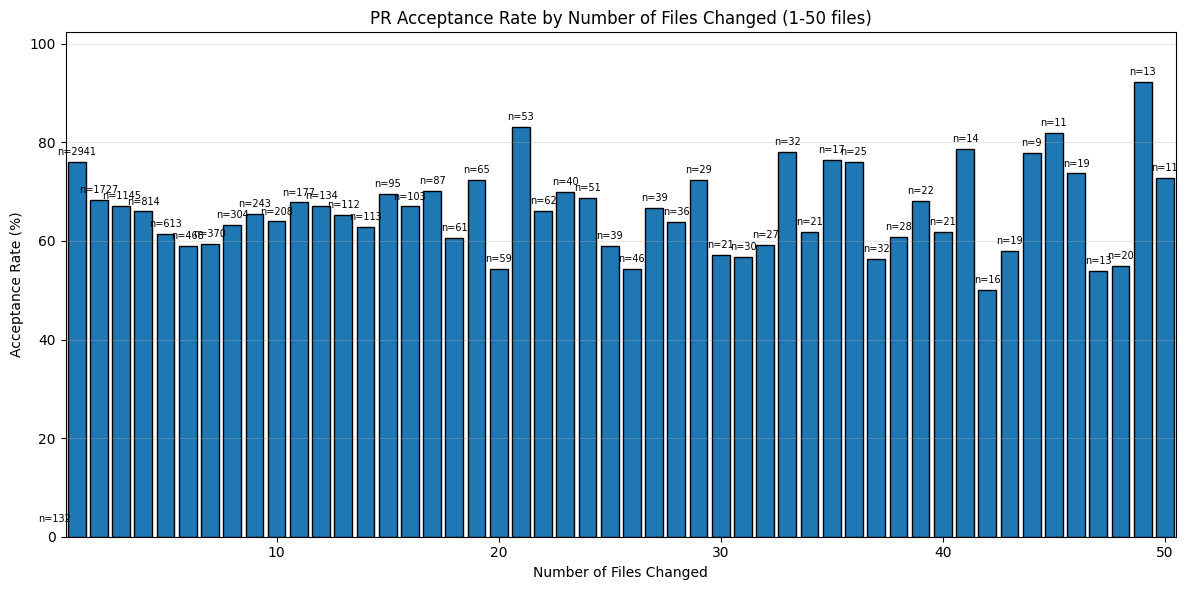

In [7]:
# Create histogram of acceptance rate by files changed (1-50 files)
file_data = pr_df[pr_df['num_files_changed'] <= 50].groupby('num_files_changed').agg({
    'accepted': ['sum', 'count']
}).reset_index()

file_data.columns = ['num_files_changed', 'accepted_count', 'total_count']
file_data['acceptance_rate'] = (file_data['accepted_count'] / file_data['total_count']) * 100

plt.figure(figsize=(12, 6))
bars = plt.bar(file_data['num_files_changed'], file_data['acceptance_rate'], 
               edgecolor='black', width=0.8)

# Add n labels on each bar
for idx, row in file_data.iterrows():
    plt.text(row['num_files_changed'], row['acceptance_rate'] + 1, 
             f"n={int(row['total_count'])}", 
             ha='center', va='bottom', fontsize=7)

plt.xlabel('Number of Files Changed')
plt.ylabel('Acceptance Rate (%)')
plt.title('PR Acceptance Rate by Number of Files Changed (1-50 files)')
plt.xlim(0.5, 50.5)
plt.ylim(0, max(file_data['acceptance_rate']) + 10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## PR Touches Test Files

Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False            5059         7139            2080   
1               True            3082         4823            1741   

   acceptance_rate  
0        70.864267  
1        63.902136  

Contingency Table:
accepted           False  True 
touches_test_file              
False               2080   5059
True                1741   3082

Chi-square statistic: 63.8584
P-value: 0.00000000000000133690
Degrees of freedom: 1
Statistical significance: Yes (p < 0.005)



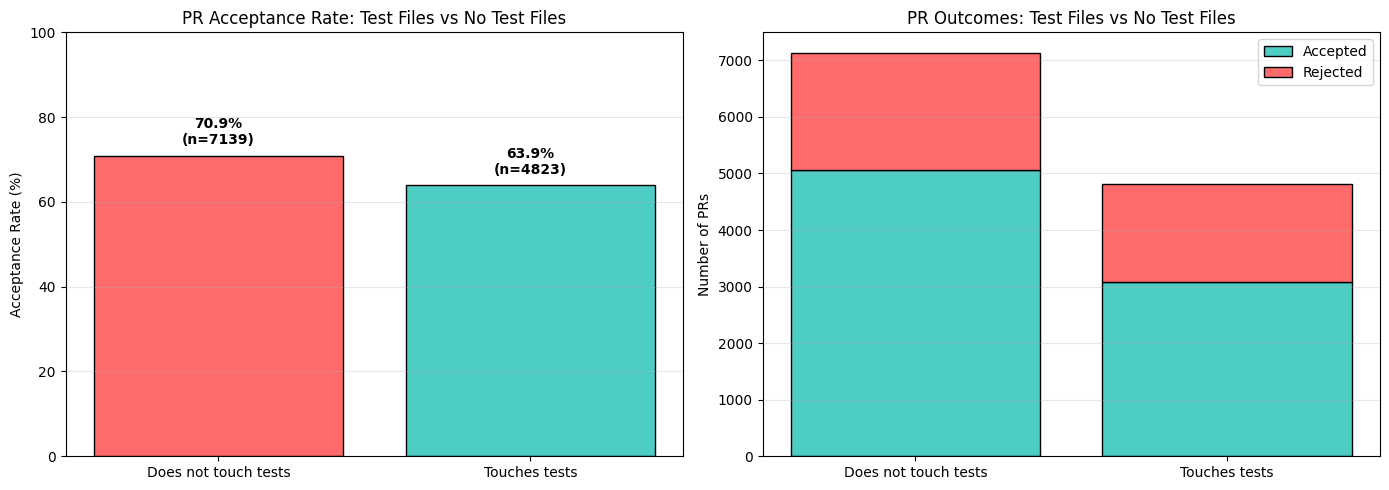

In [8]:
analyze_boolean_factor(pr_df, 'touches_test_file', 
                      label_false='Does not touch tests', 
                      label_true='Touches tests',
                      title_suffix='Test Files vs No Test Files')
None